In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_dir = 'fer2013/train'
test_dir = 'fer2013/test'

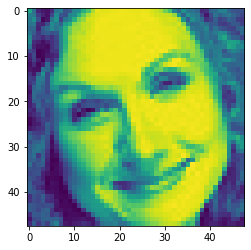

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
img = image.load_img('fer2013/train/happy/Training_10181727.jpg', target_size=(48,48), color_mode='grayscale')
plt.imshow(img)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rotation_range=20,
                              rescale=1./255,
                              shear_range=0.1,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              width_shift_range=0.1,
                              height_shift_range=0.1)

training_data = train_gen.flow_from_directory(train_dir,
                                             target_size=(224,224),
                                             batch_size=64,
                                             color_mode = "grayscale",
                                             class_mode = "categorical")

Found 28709 images belonging to 7 classes.


In [6]:
valid_gen = ImageDataGenerator(rescale=1./255)

valid_data = valid_gen.flow_from_directory(test_dir,
                                          target_size=(224,224),
                                          batch_size=64,
                                          color_mode='grayscale',
                                          class_mode='categorical')

Found 7178 images belonging to 7 classes.


In [7]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

80142336/80134624 [==============================] - 23s 0us/step


In [8]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model

input = Input(shape=(224,224,1))

conv = Conv2D(3, kernel_size=(3,3), padding='same')(input)

vgg = vgg(conv)
    
x = Flatten()(vgg)

pred = Dense(7, activation='softmax')(x)

model = Model(inputs=input, outputs=pred)

In [9]:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense

# model = tf.keras.models.Sequential()

# model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(48, 48,1)))
# model.add(Conv2D(32, kernel_size=3, activation='relu' ))
# model.add(BatchNormalization())
# model.add(MaxPool2D())
# model.add(Dropout(0.2))

# model.add(Conv2D(64, kernel_size=3, activation='relu'))
# model.add(Conv2D(64, kernel_size=3, activation='relu' ))
# model.add(BatchNormalization())
# model.add(MaxPool2D())
# model.add(Dropout(0.2))

# model.add(Conv2D(128, kernel_size=3, activation='relu'))
# model.add(Conv2D(128, kernel_size=3, activation='relu' ))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(3,3)))
# model.add(Dropout(0.2))

# model.add(Flatten())

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(7, activation='softmax'))

# tf.keras.utils.plot_model(model, 'model.png')

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       30        
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 175623    
Total params: 20,200,037
Trainable params: 175,653
Non-trainable params: 20,024,384
_________________________________________________________________


In [11]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt,
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

In [ ]:
history = model.fit(training_data, epochs=100, validation_data = valid_data)

Epoch 1/100
 40/449 [=>............................] - ETA: 4:55:33 - loss: 1.8414 - accuracy: 0.2352

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(training_data)
test_loss, test_acc = model.evaluate(valid_data)

In [ ]:
test_img = image.load_img('../input/fer2013/test/angry/PrivateTest_13278552.jpg',target_size = (224,224),color_mode = "grayscale")
plt.imshow(test_img)

In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

test_img = np.expand_dims(test_img,axis = 0)
test_img = test_img.reshape(1,224,224,1)
result = model.predict(test_img)
result = list(result[0])

img_index = result.index(max(result))
print(label_dict[img_index])

In [ ]:
model.save('model_optimal.h5')